# BTW sandpile model code 
#### (Could use some optimisation)

Starting with a sandpile model with no voids and then adding voids later.

In [18]:
# Dependencies for both sections
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import csv

In [19]:
# Function to calculate radius
def radius_shortcut(vector_j, near):
    if near == True:
        rad = ((vector_j[2] - vector_j[0])**2 + (vector_j[3] - vector_j[1])**2)**(0.5)
    else:
        rad = ((vector_j[4] - vector_j[0])**2 + (vector_j[5] - vector_j[1])**2)**(0.5)

    return rad[0]

In [20]:
# This function performs the avalanche operation in the sandpile model
# Updates sand matrix / event matrix / vector of radii (floats)
def cascader_updated4(N, sand_matrix, prev_updt, event_add, m, k, rolling_radius, time_counter ):
    #matrix manipulation
    inter_matrix = np.zeros((N+2,N+2), dtype=int)
    topple_map = sand_matrix // 4 #Clever
    UP = np.s_[0:N, 1:N+1]
    DOWN = np.s_[2:N+2, 1:N+1]
    LEFT = np.s_[1:N+1, 0:N]
    RIGHT = np.s_[1:N+1, 2:N+2]
    MIDDLE = np.s_[1:N+1, 1:N+1]
    inter_matrix[UP] += topple_map
    inter_matrix[DOWN] += topple_map
    inter_matrix[LEFT] += topple_map
    inter_matrix[RIGHT] += topple_map
    inter_matrix = inter_matrix[MIDDLE]
    prev_updt += topple_map

    #update sand matrix
    sand_matrix += inter_matrix
    sand_matrix -= 4*topple_map

    #update event vector
    event_add[0][1] = time_counter #life-time
    event_add[0][2] += np.sum(topple_map) #size
    event_add[0][3] = np.count_nonzero(prev_updt == 1)# unique area
    event_add[0][4] = (np.sum(sand_matrix) + 1)  #mass

    #calculate radius
    coordinate_vec = np.zeros((4,1))
    rowscols = np.argwhere(topple_map>0)
    coordinate_vec[0] = rowscols[0][0] 
    coordinate_vec[1] = rowscols[0][1] 
    coordinate_vec[2] = rowscols[len(rowscols)-1][0] 
    coordinate_vec[3] = rowscols[len(rowscols)-1][1] 

    rolling_rad1 = radius_shortcut([m, k, coordinate_vec[0], coordinate_vec[1], coordinate_vec[2], coordinate_vec[3]], True)
    rolling_rad2 = radius_shortcut([m, k, coordinate_vec[0], coordinate_vec[1], coordinate_vec[2], coordinate_vec[3]],  False)
    interum_radi = 0.0
    if rolling_rad1 > rolling_rad2:
        interum_radi = rolling_rad1
    else:
        interum_radi = rolling_rad2

    if interum_radi > rolling_radius:
        rolling_radius = interum_radi
        
    return rolling_radius 

The sand_pile_simulation4(N,t) function creates a CSV containing all the event data that occurs during the simulation. The CSV file has five columns containing the following data: [0:"time", 1:"life-time", 2:"size", 3:"area", 4:"mass"].

In [21]:
# Sand pile simulator 
def sand_pile_simulation4(N,t):
    csv_name = "SP"+str(N)+","+str(t)
    with open(str(csv_name)+'.csv', 'w',newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter =',')
        writer.writerow(['time','life-time','size','area','mass','radius'])

    sand_matrix = np.zeros((N,N), dtype=int)
    prev_updt = np.zeros((N,N), dtype=int)

    for i in range(t):
        check = np.any(sand_matrix >= 4)

        if check == False:
           m = random.randint(0, (N-1)) 
           k = random.randint(0, (N-1)) 
           sand_matrix[m,k] += 1 

        else:
            event_add = np.zeros((1,5), dtype=int) #[0:"time", 1:"life-time", 2:"size", 3:"area", 4:"mass"]
            event_add[0][0] = i
            rolling_radius = 0.0
            time_counter = 0

            while check == True:
                time_counter += 1
                rolling_radius = cascader_updated4(N, sand_matrix, prev_updt, event_add, m, k, rolling_radius, time_counter )#
                check = np.any(sand_matrix >= 4)

            with open(str(csv_name)+'.csv', 'a',newline='') as csvfile:
                writer = csv.writer(csvfile, delimiter =',')
                writer.writerow([event_add[0][0],event_add[0][1],event_add[0][2],event_add[0][3],event_add[0][4],rolling_radius])

            m = random.randint(0, (N-1)) 
            k = random.randint(0, (N-1)) 
            sand_matrix[m,k] += 1 
            prev_updt = np.zeros((N,N), dtype=int)

    return sand_matrix

This code below runs the defined functions and outputs the CSV file.

In [22]:
#Choose variables and run simulation
N = 20
t = 10000 
sand_matrix = sand_pile_simulation4(N,t)

#### Working with the CSV file

Read the CSV file that was saved to the same directory, load in the data.

In [23]:
csv_name = "SP"+str(N)+","+str(t)
df = pd.read_csv(csv_name+'.csv')

In [24]:
# Add new column of data, the time between avalanches
df["interval"] = df["time"].diff()
df.loc[0, "interval"] = 0

Example of the data generated:

In [25]:
df

,time,life-time,size,area,mass,radius,interval
0,112,1,1,1,113,0.000000,0.0
1,174,1,1,1,174,0.000000,62.0
2,230,1,1,1,230,0.000000,56.0
3,236,1,1,1,235,0.000000,6.0
4,238,1,1,1,236,0.000000,2.0
...,...,...,...,...,...,...,...
3902,9993,1,1,1,843,0.000000,2.0
3903,9994,23,73,73,830,12.806248,1.0
3904,9995,3,3,3,830,1.414214,1.0
3905,9996,40,299,114,821,10.630146,1.0


Now we need to transform this data and plot our results.

In [26]:
#Use this dataframe to get a vector of the mass of the pile over time.
mass_vec = np.zeros(t-1,dtype=int)
count_t = 0
for j in range(t-1):
    mass_vec[j] = mass_vec[j-1] + 1
    if df["time"][count_t] == j:
        mass_vec[j] = df["mass"][count_t]
        if count_t < len(df)-1:
            count_t += 1


Text(0.5, 1.0, 'mass vs time')

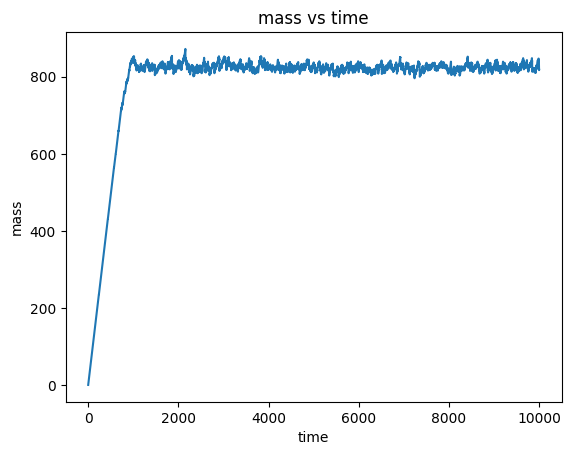

In [27]:
#Plot mass over time
plt.plot(mass_vec)
plt.xlabel('time')
plt.ylabel('mass')
plt.title('mass vs time')

Plot interval frequency vs count on a log-log plot.

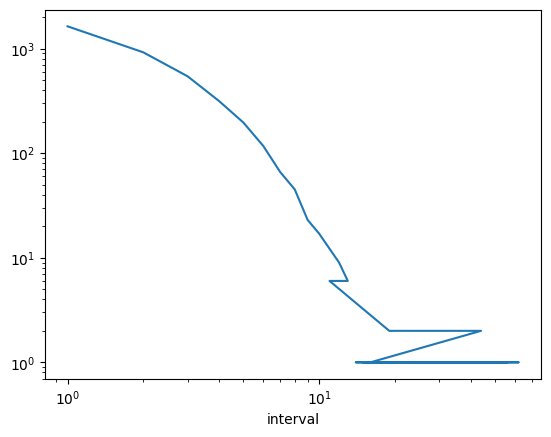

In [28]:
(df["interval"][1:].value_counts()).plot()
plt.yscale('log')
plt.xscale('log')

## Now we can add voids!

#### (We need to update our previous functions to handle voids)

In [29]:
# Avalanche operator, void inclusive
def cascader_updated5(N, sand_matrix, prev_updt, event_add, m, k, rolling_radius, time_counter, void_list):
    #matrix manipulation /// include voids
    inter_matrix = np.zeros((N+2,N+2), dtype=int)
    topple_map = sand_matrix // 4 
    UP = np.s_[0:N, 1:N+1]
    DOWN = np.s_[2:N+2, 1:N+1]
    LEFT = np.s_[1:N+1, 0:N]
    RIGHT = np.s_[1:N+1, 2:N+2]
    MIDDLE = np.s_[1:N+1, 1:N+1]
    inter_matrix[UP] += topple_map
    inter_matrix[DOWN] += topple_map
    inter_matrix[LEFT] += topple_map
    inter_matrix[RIGHT] += topple_map
    inter_matrix = inter_matrix[MIDDLE]
    prev_updt += topple_map

    #update sand matrix
    sand_matrix += inter_matrix
    sand_matrix -= 4*topple_map

    #voids
    for j in range(len(void_list)):
        jv = void_list[j]
        sand_matrix[jv[0]][jv[1]] = 0

    #update event vector
    event_add[0][1] = time_counter #life-time
    event_add[0][2] += np.sum(topple_map) #size
    event_add[0][3] = np.count_nonzero(prev_updt == 1)# unique area
    event_add[0][4] = (np.sum(sand_matrix) + 1)  #mass

    #calculate radius
    coordinate_vec = np.zeros((4,1))
    rowscols = np.argwhere(topple_map>0)
    coordinate_vec[0] = rowscols[0][0] 
    coordinate_vec[1] = rowscols[0][1] 
    coordinate_vec[2] = rowscols[len(rowscols)-1][0] 
    coordinate_vec[3] = rowscols[len(rowscols)-1][1] 

    rolling_rad1 = radius_shortcut([m, k, coordinate_vec[0], coordinate_vec[1], coordinate_vec[2], coordinate_vec[3]], True)
    rolling_rad2 = radius_shortcut([m, k, coordinate_vec[0], coordinate_vec[1], coordinate_vec[2], coordinate_vec[3]],  False)
    interum_radi = 0.0
    if rolling_rad1 > rolling_rad2:
        interum_radi = rolling_rad1
    else:
        interum_radi = rolling_rad2

    if interum_radi > rolling_radius:
        rolling_radius = interum_radi
        
    return rolling_radius 

In [30]:
# Sandpile simulation, void inclusive
def sand_pile_simulation5_1(N,t,voids,novoids, v_id):
    csv_name = "SP"+str(N)+","+str(t)+v_id
    with open(str(csv_name)+'.csv', 'w',newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter =',')
        writer.writerow(['time','life-time','size','area','mass','radius'])

    sand_matrix = np.zeros((N,N), dtype=int)
    prev_updt = np.zeros((N,N), dtype=int)

    for i in range(t):
        check = np.any(sand_matrix >= 4)

        if check == False:
            rannum = random.randint(0, len(novoids)-1) 
            non_void = novoids[rannum]
            m = non_void[0]
            k = non_void[1]
            sand_matrix[m,k] += 1 


        else:
            event_add = np.zeros((1,5), dtype=int) #[0:"time", 1:"life-time", 2:"size", 3:"area", 4:"mass"]
            event_add[0][0] = i
            rolling_radius = 0.0
            time_counter = 0

            while check == True:
                time_counter += 1
                rolling_radius = cascader_updated5(N, sand_matrix, prev_updt, event_add, m, k, rolling_radius, time_counter, voids)
                check = np.any(sand_matrix >= 4)

            with open(str(csv_name)+'.csv', 'a',newline='') as csvfile:
                writer = csv.writer(csvfile, delimiter =',')
                writer.writerow([event_add[0][0],event_add[0][1],event_add[0][2],event_add[0][3],event_add[0][4],rolling_radius])

            rannum = random.randint(0, len(novoids)-1) 
            non_void = novoids[rannum]
            m = non_void[0]
            k = non_void[1]
            sand_matrix[m,k] += 1 
            prev_updt = np.zeros((N,N), dtype=int)
      
    return sand_matrix

Define a void shape and run the simulation, it will generate a CSV file like last time:

In [31]:
# Diamond shaped void, creates two lists, containing the coordinates of all voids / non-void grids
def diamond_void2(N):
    v_list = []
    count = 1
    for i in range(int(N/2)):
        num2 = int(N/2)- (1+ i)
        iterate = list(range(0,num2))
        for j in range(len(iterate)):
            end = N-1
            v_list.append([i,iterate[j]])
            v_list.append([(end-i),iterate[j]])
            #other side
            ots = iterate[j] + (N-1) - 2*j
            v_list.append([i,ots])
            v_list.append([(end-i),ots])

    fillin = np.zeros((N,N), dtype=int)
    for k in range(len(v_list)):
        fin = v_list[k]
        fillin[fin[0]][fin[1]] += 1

    novoids = []
    for l in range(N):
        for p in range(N):
            if fillin[l,p] != 1:
                novoids.append([l,p])

    return v_list, novoids


In [32]:
N = 60
t = 50000

voids, novoids = diamond_void2(N)
v_id = "vDT_1"

sand_matrix = sand_pile_simulation5_1(N,t,voids,novoids,v_id)


Read in the CSV data and plot the mass vs time again.

Text(0.5, 1.0, 'mass vs time')

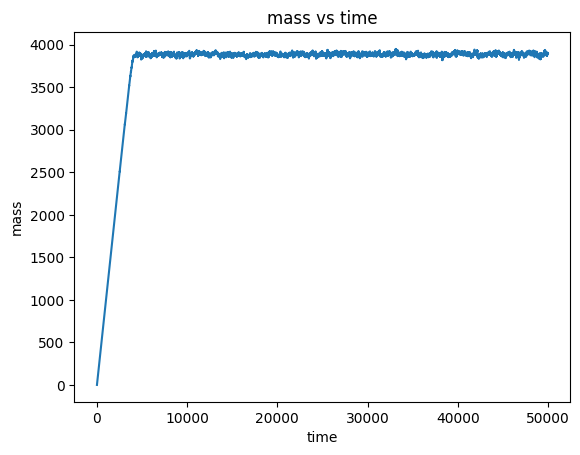

In [33]:
csv_name = "SP"+str(N)+","+str(t)+v_id
df2 = pd.read_csv(csv_name+'.csv')

#Use this dataframe to get a vector of the mass of the pile over time.
mass_vec2 = np.zeros(t-1,dtype=int)
count_t = 0
for j in range(t-1):
    mass_vec2[j] = mass_vec2[j-1] + 1
    if df2["time"][count_t] == j:
        mass_vec2[j] = df2["mass"][count_t]
        if count_t < len(df2)-1:
            count_t += 1

#Plot mass over time
plt.plot(mass_vec2)
plt.xlabel('time')
plt.ylabel('mass')
plt.title('mass vs time')